In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import root_mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor
from hyperopt import fmin, tpe, hp, Trials, space_eval, STATUS_OK
from hyperopt.pyll.base import scope


import pickle
import mlflow
from mlflow.client import MlflowClient


# reset color and other runtime configs
plt.rcParams.update(plt.rcParamsDefault)

%matplotlib inline

# apply a ploting style
plt.style.use("seaborn-v0_8-talk")

## Setup MLflow Experiment Tracking

- Connect to the MLflow tracking URL, in this case, an SQLite DB. The MLflow server should already be running `mlflow server --backend-store-uri sqlite:///mlflow.db`
- Start or connect to an existing experiment

In [2]:
mlflow_tracking_url = "sqlite:///../data/mlflow.db"
experiment_name = "trotro-duration-experiment2"
mlflow.set_tracking_uri(mlflow_tracking_url)
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='/Users/asare/source/trotro_mlops/mlruns/3', creation_time=1730100029569, experiment_id='3', last_update_time=1730100029569, lifecycle_stage='active', name='trotro-duration-experiment2', tags={}>

## Track experiment with MLflow

The experiment steps include:
- Loading data
- Hyperparameter tuning with hyperopt
- Training and validating the model with the best hyperparameters
- Testing the model by loading the saved model, preprocessing, and predicting on sample data


In [4]:
categorical_features = ["PULocationID", "DOLocationID", "RatecodeID"]
numerical_features = ["trip_distance", "passenger_count", "hour_of_day"]
target = "duration"


def load_data(filename):
    df = pd.read_parquet(filename)
    df = df[df.passenger_count > 0]

    df["duration"] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df["duration"] = df["duration"].dt.total_seconds() / 60
    df["hour_of_day"] = df.tpep_pickup_datetime.dt.hour
    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical_features = ["PULocationID", "DOLocationID", "RatecodeID"]
    numerical_features = ["trip_distance", "passenger_count", "hour_of_day", "duration"]
    df[categorical_features] = df[categorical_features].astype(int).astype(str)
    df = df[categorical_features + numerical_features]

    return df


def hyperparameter_tuning(df_train, df_val):
    print(f"tuning hyperparameters ....")

    train_dicts = df_train[categorical_features + numerical_features].to_dict(
        orient="records"
    )
    val_dicts = df_val[categorical_features + numerical_features].to_dict(
        orient="records"
    )

    print("preprocessing data...")
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)
    y_train = df_train[target].values

    X_val = dv.transform(val_dicts)
    y_val = df_val[target].values

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    mlflow.log_param("train_dataset", "./data/yellow_tripdata_2024-01.parquet")
    mlflow.log_param("validation_dataset", "./data/yellow_tripdata_2024-02.parquet")

    def objective(params):
        with mlflow.start_run(nested=True):
            mlflow.log_params(params)
            mlflow.set_tag("model", "xgboost")
            mlflow.set_tag("process", "hyperparameter_tuning")

            xgb_model = xgb.train(
                params,
                dtrain,
                num_boost_round=10,
                evals=[(dval, "validation")],
                early_stopping_rounds=5,
            )
            y_pred = xgb_model.predict(dval)
            rmse = root_mean_squared_error(y_val, y_pred)
            mlflow.log_metric("rmse", rmse)

            return {"loss": rmse, "status": STATUS_OK}

    search_space = {
        "learning_rate": hp.loguniform("learning_rate", -3, 0),
        "max_depth": scope.int(hp.quniform("max_depth", 1, 10, 1)),
        "objective": "reg:squarederror",
        "seed": 42,
    }

    print("optimizing hyperparameters...")
    best_result = fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=10,
        trials=Trials(),
    )

    best_params = space_eval(search_space, best_result)
    print(f"best hyperparameters: {best_params}")

    return best_params


def train_model(df_train, df_val, params):
    print(f"training model with optimized hyperparameters {params}")
    mlflow.xgboost.autolog()

    train_dicts = df_train[categorical_features + numerical_features].to_dict(
        orient="records"
    )
    val_dicts = df_val[categorical_features + numerical_features].to_dict(
        orient="records"
    )

    print("preprocessing data...")
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)
    y_train = df_train[target].values

    # save the preprocessor
    os.makedirs("models", exist_ok=True)
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    X_val = dv.transform(val_dicts)
    y_val = df_val[target].values

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    mlflow.log_param("train_dataset", "./data/yellow_tripdata_2024-01.parquet")
    mlflow.log_param("validation_dataset", "./data/yellow_tripdata_2024-02.parquet")
    mlflow.log_param("estimator", "XGBRegressor")
    mlflow.log_param("train_samples", df_train.shape[0])
    mlflow.log_param("validation_samples", df_val.shape[0])
    mlflow.log_param("features", categorical_features + numerical_features)
    mlflow.log_param("target", target)

    xgb_model = xgb.train(
        params,
        dtrain,
        num_boost_round=10,
        evals=[(dval, "validation")],
        early_stopping_rounds=5,
    )

    y_pred_val = xgb_model.predict(dval)
    y_pred_train = xgb_model.predict(dtrain)
    rmse_val = root_mean_squared_error(y_val, y_pred_val)
    mlflow.log_metric("rmse", rmse_val)
    print(f"RMSE: {rmse_val:.2f}")

    fig_train = plot_pred_distribution(
        y=y_train,
        y_pred=y_pred_train,
        y_label="Actual (Train dataset)",
        y_pred_label="Predicted (Train dataset)",
        x_label="Duration (min)",
        title="Actual vs Predicted Duration Distribution",
    )
    mlflow.log_figure(fig_train, "train_dist.png")

    fig_val = plot_pred_distribution(
        y=y_val,
        y_pred=y_pred_val,
        y_label="Actual (Validation dataset)",
        y_pred_label="Predicted (Validation dataset)",
        x_label="Duration (min)",
        title="Actual vs Predicted Duration Distribution",
    )

    mlflow.log_figure(fig_val, "val_dist.png")

    return dv, xgb_model


def predict(data, run_id):
    print(f"predicting with final model ....")
    mlflowClient = MlflowClient()
    model_uri = f"runs:/{run_id}/model"
    artifact_path = "preprocessor/preprocessor.b"
    print(f"model_uri: {model_uri}")

    local_preprocessor_path = mlflowClient.download_artifacts(run_id, artifact_path)

    with open(local_preprocessor_path, "rb") as f_in:
        dv = pickle.load(f_in)

    loaded_model = mlflow.pyfunc.load_model(model_uri)

    data_dicts = data[categorical_features + numerical_features].to_dict(
        orient="records"
    )

    X = dv.transform(data_dicts)
    y_pred = loaded_model.predict(X)
    data["predicted_duration"] = y_pred
    print(f"predictions: {data[['duration', 'predicted_duration']]}")
    return data


def plot_pred_distribution(y, y_pred, y_label, y_pred_label, x_label, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.kdeplot(y, label=y_label, fill=True)
    sns.kdeplot(y_pred, label=y_pred_label, fill=True)
    plt.xlabel(x_label)
    plt.title(title)
    plt.legend()
    plt.show()
    return fig


def main():
    with mlflow.start_run() as run:
        print(f"Starting run: {run.info.run_name} with run_id: {run.info.run_id}")

        print("loading data...")
        df_train = load_data("../data/yellow_tripdata_2024-01.parquet")
        df_val = load_data("../data/yellow_tripdata_2024-02.parquet")
        df_test = load_data("../data/yellow_tripdata_2024-03.parquet")

        best_result = hyperparameter_tuning(df_train, df_val)
        train_model(df_train, df_val, best_result)
        test_data = df_test.sample(10, random_state=1)
        predict(test_data, run.info.run_id)

        print(
            f"Run {run.info.run_name} with run_id: {run.info.run_id} completed successfully"
        )

## Running the experiment

Starting run:omniscient-eel-659 with run_id: dedf93405fd947538697092da8d0ede0
loading data...
tuning hyperparameters ....
preprocessing data...
optimizing hyperparameters...
[0]	validation-rmse:7.21258                           
[1]	validation-rmse:5.82126                           
[2]	validation-rmse:5.24998                           
[3]	validation-rmse:5.01663                           
[4]	validation-rmse:4.90716                           
[5]	validation-rmse:4.83929                           
[6]	validation-rmse:4.79351                           
[7]	validation-rmse:4.76539                           
[8]	validation-rmse:4.73876                           
[9]	validation-rmse:4.72236                           
[0]	validation-rmse:5.75180                                                    
[1]	validation-rmse:5.23495                                                    
[2]	validation-rmse:5.11837                                                    
[3]	validation-rmse:5.07931         

2024/10/29 11:38:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/trotro/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [11:38:59] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
python(14889) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


RMSE: 4.72


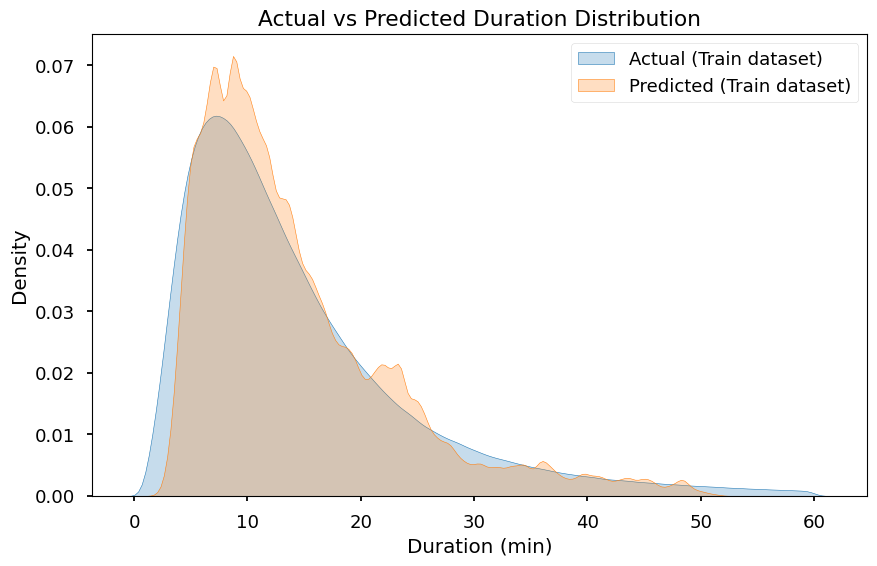

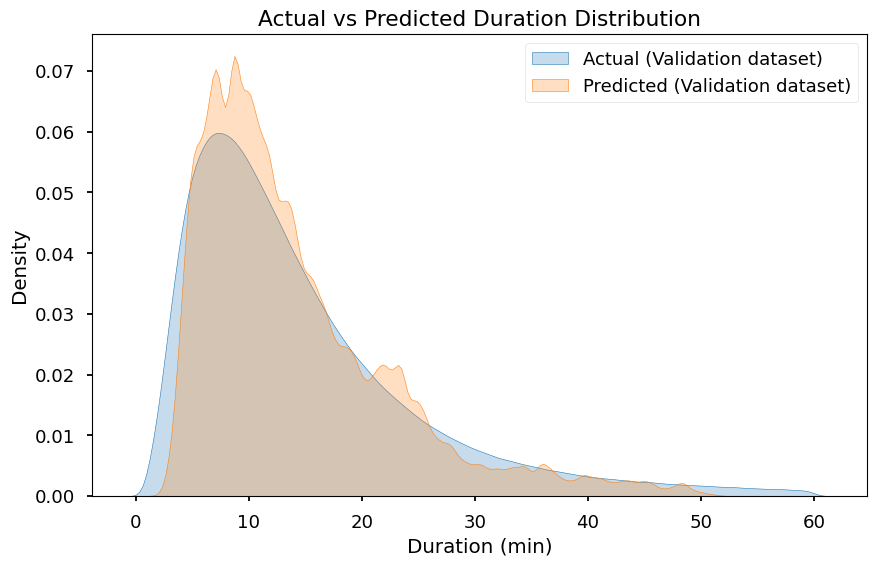

predicting with final model ....
model_uri: runs:/dedf93405fd947538697092da8d0ede0/model
predictions:           duration  predicted_duration
2088014  37.033333           25.798195
2749323  12.000000           22.046028
1118346   4.366667            7.856165
545269   17.133333           12.792296
931256    9.900000           11.987305
1890909  19.983333           19.550850
2304121   7.100000            5.450332
741710   19.433333           19.618006
350781   17.400000           22.531492
686283   56.300000           39.812691


In [5]:
main()

## Search for the runs 

- The best models can be found the UI or via the python API


In [10]:
from mlflow.client import MlflowClient
from mlflow.entities import ViewType

client = MlflowClient()

experiment_id = client.get_experiment_by_name(experiment_name).experiment_id
runs = client.search_runs(
    experiment_ids=[experiment_id],
    order_by=["metrics.rmse ASC"],
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
)
for run in runs:
    print(f"run_id: {run.info.run_id}, rmse: {run.data.metrics['rmse']}")

run_id: d5f41eff521645639b94eb25a0e02970, rmse: 4.7219771376496436
run_id: b517c1be6f0c4677915cef5deb48eac8, rmse: 4.7219771376496436
run_id: b24bd3eb9e1749daa20ec87d4c8e847f, rmse: 4.722359214969617
run_id: dedf93405fd947538697092da8d0ede0, rmse: 4.722359214969617
run_id: 948b5c09aa324804a576592d32a536ea, rmse: 4.728821497805649


## Register a model


In [8]:
def register_model(run_id, model_name):
    mlflow.set_tracking_uri(mlflow_tracking_url)
    model_uri = f"runs:/{run_id}/model"

    mlflow.register_model(model_uri=model_uri, name=model_name)

In [9]:
run_id = "d5f41eff521645639b94eb25a0e02970"
model_name = "trotro-duration"

register_model(run_id, model_name)

Registered model 'trotro-duration' already exists. Creating a new version of this model...
Created version '2' of model 'trotro-duration'.
